# Assignment 4: lower limbs kinematics
**Charles Pontonnier**


## Input data discovery



This python code is dedicated to explore C3D (motion capture) data and use it in a kinematics analysis.

To proceed with this code, it is necessary to use the ezc3d library. To install the library, please open an anaconda shell and prompt:

conda install -c conda-forge ezc3d 

## Markerset
![alt text](markerset.png "jeu de marqueurs utilisé")

## Notebook setup

In [2]:
import ezc3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## opening the C3D file and get the data 

In [3]:
#Opening the file
c = ezc3d.c3d('DATA/walk.c3d')

## Printing the dictionaries contents
#print(c['header'].keys())
#print(c['data'].keys())
#print(c['parameters']['FORCE_PLATFORM'].keys())

point_data = c['data']['points'] #markers trajectories
point_labels=c['parameters']['POINT']['LABELS']# markers labels
point_rate=c['parameters']['POINT']['RATE'] # mocap framerate
analog_data = c['data']['analogs'] # analog data
analog_labels=c['parameters']['ANALOG']['LABELS'] # analog data labels
analog_rate=c['parameters']['ANALOG']['RATE'] # analogs framerate

print('mocap frequency:', point_rate['value'][0],'Hz')
print('analogs frequency:', analog_rate['value'][0],'Hz')
# number of frames and samples
nf_mocap=len(point_data[0][0][:])
n_markers=len(point_data[0][:])
n_dims=len(point_data[:])
nf_analog=len(analog_data[0][:][:])
#analog and mocap times
t_point=np.linspace(0., nf_mocap/point_rate['value'][0], num=nf_mocap)
t_analog=np.linspace(0., nf_analog/analog_rate['value'][0], num=nf_analog)

print('Markers names',point_labels)
print('Number of markers',n_markers)
print('Dimensions',n_dims)
print('Number of frames',nf_mocap)




mocap frequency: 300.0 Hz
analogs frequency: 1500.0 Hz
Markers names {'type': -1, 'description': 'Trajectory labels', 'is_locked': False, 'value': ['LKNE', 'OXSENS', 'LTOE', 'LTAR', 'LTARI', 'LHEE', 'LANI', 'LANE', 'LKNI', 'LINF', 'LFWT', 'LBWT', 'RTOE', 'RTAR', 'RTARI', 'RHEE', 'RANI', 'RANE', 'RKNI', 'RKNE', 'RINF', 'RFWT', 'RBWT']}
Number of markers 23
Dimensions 4
Number of frames 1863


## Markers positions during the task

<font color='green'>**Example: Position XYZ of marker RKNE**</font>

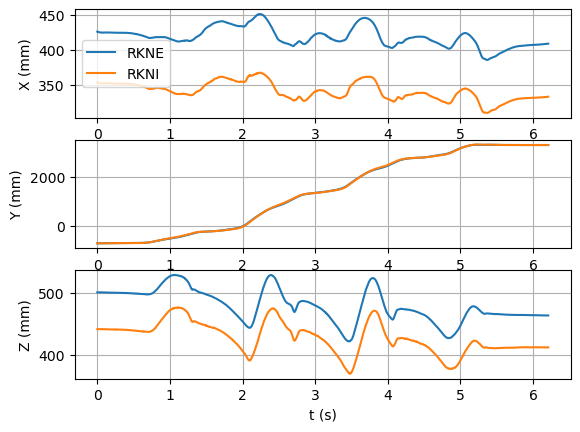

In [4]:
plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,point_data[0][19][:])
plt.plot(t_point,point_data[0][18][:])
plt.xlabel('t (s)')
plt.ylabel('X (mm)')
plt.legend([point_labels['value'][19],point_labels['value'][18]])

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,point_data[1][19][:])
plt.plot(t_point,point_data[1][18][:])
plt.xlabel('t (s)')
plt.ylabel('Y (mm)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,point_data[2][19][:])
plt.plot(t_point,point_data[2][18][:])
plt.xlabel('t (s)')
plt.ylabel('Z (mm)')

plt.show()

<font color='green'>**Question 1: Plot the marker trajectory of LKNI.**</font>

In [5]:
# See above



## Joint centers

Now we try to get the positions of the joint centers in the world CS:
![alt text](centres_articulaires.png "centres articulaires du modèle")

<font color='green'>**Question 2: Utiliser le markerset pour reconstruire les différents centres articulaires du modèle et tracer l'allure des courbes. Pour le moment on ne s'occupe pas du centre articulaire de la hanche.**</font>

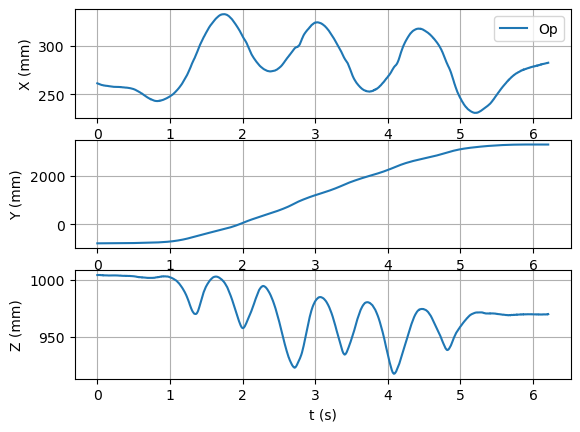

In [6]:
# Op (pelvis joint center) is approximated from the 4 pelvis markers
Op=np.zeros((3,nf_mocap))
Op[0,:]=0.25*(point_data[0][10][:]+point_data[0][11][:]+point_data[0][21][:]+point_data[0][22][:])
Op[1,:]=0.25*(point_data[1][10][:]+point_data[1][11][:]+point_data[1][21][:]+point_data[1][22][:])
Op[2,:]=0.25*(point_data[2][10][:]+point_data[2][11][:]+point_data[2][21][:]+point_data[2][22][:])

plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,Op[0,:])
plt.xlabel('t (s)')
plt.ylabel('X (mm)')
plt.legend(['Op'])

plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,Op[1,:])
plt.xlabel('t (s)')
plt.ylabel('Y (mm)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,Op[2,:])
plt.xlabel('t (s)')
plt.ylabel('Z (mm)')

plt.show()

# Oh (hip joint center) is specifically computed thereafter

# Os (knee joint center) is computed from the knee markers
# Of (ankle joint center) is computed from the ankle markers
# Otoe (the foot extremety) is approximated from the toe marker


Then we give a function able to compute the 0Rp (pelvis to world) rotation matrix at any time

Please have in mind :

0  ’LKNE’  
2  'LTOE’  
3  'LTAR’  
4  'LTARI’  
5  'LHEE’  
6  'LANI’  
7  'LANE’  
8  'LKNI’  
10 'LFWT’  
11 'LBWT’  
12 'RTOE’  
13 'RTAR’  
14 'RTARI’   
15 'RHEE’  
16 'RANI’  
17 'RANE’  
18 'RKNI’  
19 'RKNE’  
21 'RFWT’  
22 'RBWT' 

In [7]:
def Rp(markers):
    #pelvis rotation matrix
    Rp=np.zeros((3,3))

    #pelvis->world rotation matrix
    zp=(markers[21,:]-markers[10,:])/np.linalg.norm(markers[21,:]-markers[10,:]) # RFWT-LFWT
    xp=(0.5*(markers[21,:]+markers[10,:])-0.5*(markers[22,:]+markers[11,:]))/np.linalg.norm(0.5*(markers[21,:]+markers[10,:])-0.5*(markers[22,:]+markers[11,:]))
    yp=np.cross(zp,xp)
    xp=np.cross(yp,zp) # be careful, it is necessary to recompute x to be sure it is orthogonal !

    Rp[0,:]=[xp[0],yp[0],zp[0]]
    Rp[1,:]=[xp[1],yp[1],zp[1]]
    Rp[2,:]=[xp[2],yp[2],zp[2]]
    return Rp

In [8]:
markers=np.zeros((n_markers,n_dims-1)) #temporary markers positions (more convenient to manipulate the data)
f=0
for i in range(0,n_markers):
    markers[i,0]=point_data[0][i][f]
    markers[i,1]=point_data[1][i][f]
    markers[i,2]=point_data[2][i][f]

Rp0=Rp(markers)
print('Rp at frame 1=',Rp0)

Rp at frame 1= [[ 0.09003132 -0.02766857  0.99553905]
 [ 0.98244735  0.15545452 -0.0848205 ]
 [-0.15241418  0.98570121  0.04132173]]


<font color='green'>**Question 3: Use the function above to determine at any time the position of the hip in the world coordinate system Ot. We give you the following data (position of the hip in the pelvis coordinate system): pOt=[-0.0074;-0.046,0.074]**</font>

In [10]:
pOt=np.transpose([-74,-46,74])#position of the hip in the pelvis coordinate system
Ot=np.zeros((3,nf_mocap)) # position of the hip in the world coordinate system (empty for now)

 

## Inverse Kinematics IK

We will then estimate the joint angles by evaluating "y"  vectors and to compute their scalar product as the cosine of the angle.

<font color='green'>**Question 4: Exploit the data to get the joint angles. Plot the angles.**</font>

In [11]:
# y vectors of all segments
yp=np.zeros((3,nf_mocap)) #y axis pelvis
yt=np.zeros((3,nf_mocap)) #y axis thigh
ys=np.zeros((3,nf_mocap)) #y axis shank
yf=np.zeros((3,nf_mocap)) #y axis foot

# joint angles
q1=np.zeros((nf_mocap)) # q1 hip flexion/extension
q2=np.zeros((nf_mocap)) # q2 knee flexion/extension
q3=np.zeros((nf_mocap)) # q3 ankle flexion/extension







## Comparing to reference

Know we can compare the results to some litterature data:

Srinivasan, Sujatha, I. A. Raptis, and Eric R. Westervelt. "Low-dimensional sagittal plane model of normal human walking." Journal of biomechanical engineering 130.5 (2008).



![alt text](gait_angles.jpg "données de référence flexion membre inférieur")


<font color='green'>**Question 5: Isolate a single gait cycle, normalize the time between 0 and 100 and plot the angles during this cycle.**</font>

In [12]:

# using mokka, we can define a gait cycle from right heel strike to right heel strike

# for example 1428 to 1833, minus an offset of 624 frames --> from 583 to 1004

